In [1]:
import os
import sys
import gzip
import glob
import hashlib
import argparse
import numpy as np
import pandas as pd

from tqdm import tqdm
import scipy
from rdkit import Chem
from rdkit.Chem import AllChem
import lightgbm as lgb
from joblib import load

sys.path.append('src/esnuelML')
from DescriptorCreator.GraphChargeShell import GraphChargeShell
from locate_atom_sites import find_nucleophilic_sites, find_electrophilic_sites
from molecule_drawer import generate_structure, generate_output_tables, html_output
import molecule_formats as molfmt

desc_generator = GraphChargeShell()

### LOAD MCA and MAA MODELS ###
# Property prediction models:
nuc_model_path = 'src/esnuelML/models/nuc/SMI2GCS_3_cm5_model.txt.gz'
with gzip.open(nuc_model_path, mode="rt") as file:
    nuc_model_str = file.read()
nuc_model = lgb.Booster(model_str=nuc_model_str, silent=True)

elec_model_path = 'src/esnuelML/models/elec/SMI2GCS_3_cm5_model.txt.gz'
with gzip.open(elec_model_path, mode="rt") as file:
    elec_model_str = file.read()
elec_model = lgb.Booster(model_str=elec_model_str, silent=True)

# Error estimation models:
nuc_RFmodel = load('src/esnuelML/models/nuc/RF_SMI2GCS_3_cm5.joblib')
elec_RFmodel = load('src/esnuelML/models/elec/RF_SMI2GCS_3_cm5.joblib')
### END ###

SQM folder is: 
/Users/nicolairee/KU_data/esnuelML/ESNUEL_ML/desc_calcs


/Users/nicolairee/opt/miniforge3/envs/alfabet/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/nicolairee/opt/miniforge3/envs/alfabet/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [2]:
from scipy import stats
from sklearn import metrics
import seaborn as sns
sns.set_theme(style='whitegrid')

from IPython.display import SVG, HTML
from rdkit.Chem.Draw import MolsToGridImage, MolToImage
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True # Change output to SVG format
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400,400

In [3]:
def estimate_uncertainty(RFmodel, descs):
    tree_predictions = []
    for tree in RFmodel.estimators_:
        tree_predictions.append(tree.predict(descs))
    return np.std(tree_predictions, axis=0)


def run_MAA_and_MCA_predictions(name, smiles):

    smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
    
    # Calculate CM5 atomic charges
    file_path = f'desc_calcs/{name.split("_")[0]}/{name}_xtb.out'
    if os.path.isfile(file_path):
        rdkit_molHs = Chem.AddHs(Chem.MolFromSmiles(smiles))

        # Get CM5 charges from output and append CM5 charges to RDKit mol object 
        cm5_list = []
        natoms = int(rdkit_molHs.GetNumAtoms())
        with open(file_path, 'r') as output:
            for line_idx, line in enumerate(output):
                if 'Mulliken/CM5' in line:
                    start = line_idx + 1
                    endindex = start + natoms
                    for i in range(start, endindex):
                        line = output.readline(i)
                        cm5_atom = float(line.split()[2])
                        cm5_list.append(cm5_atom)
                    break
        
        desc_generator.rdkit_mol = rdkit_molHs
        desc_generator.cm5_list = cm5_list
    else:
        cm5_list = desc_generator.calc_CM5_charges(smiles, name=name, optimize=False, save_output=True)

        # Save structures in SDF format
        writer = Chem.rdmolfiles.SDWriter(desc_generator.xyz_file_path.replace('.xyz', '.sdf'))
        writer.write(desc_generator.rdkit_mol)
        writer.close()

    # Locate MAA and MCA sites
    elec_sites, elec_names, elec_smirks = find_electrophilic_sites(desc_generator.rdkit_mol) # elec_sites: site in reactant, elec_names: name of functional group
    nuc_sites, nuc_names, nuc_smirks = find_nucleophilic_sites(desc_generator.rdkit_mol) # nuc_sites: site in reactant, nuc_names: name of functional group

    # Generate atomic descriptors
    common_sites = list(set(elec_sites) & set(nuc_sites))
    common_descriptor_vectors, _ = desc_generator.create_descriptor_vector(common_sites, n_shells=3, max_neighbors=4, use_cip_sort=True)

    elec_sites_without_common = list(set(elec_sites) - set(common_sites))
    elec_without_common_descriptor_vectors, _ = desc_generator.create_descriptor_vector(elec_sites_without_common, n_shells=3, max_neighbors=4, use_cip_sort=True)
    
    nuc_sites_without_common = list(set(nuc_sites) - set(common_sites))
    nuc_without_common_descriptor_vectors, _ = desc_generator.create_descriptor_vector(nuc_sites_without_common, n_shells=3, max_neighbors=4, use_cip_sort=True)

    # Predict MAA values
    elec_descriptor_vectors = []
    for site in elec_sites:
        if site in common_sites:
            idx = common_sites.index(site)
            elec_descriptor_vectors.append(common_descriptor_vectors[idx])
        else:
            idx = elec_sites_without_common.index(site)
            elec_descriptor_vectors.append(elec_without_common_descriptor_vectors[idx])

    if len(elec_descriptor_vectors):
        elec_preds = elec_model.predict(elec_descriptor_vectors, num_iteration=elec_model.best_iteration)
        elec_errors = 0.6028123658016926 * estimate_uncertainty(elec_RFmodel, elec_descriptor_vectors) + 4.044501905413345 # If errors are above cutoff of 30.0 kJ/mol, we recommend running QM calculations
    else:
        elec_preds = []
        elec_errors = []

    # Predict MCA values
    nuc_descriptor_vectors = []
    for site in nuc_sites:
        if site in common_sites:
            idx = common_sites.index(site)
            nuc_descriptor_vectors.append(common_descriptor_vectors[idx])
        else:
            idx = nuc_sites_without_common.index(site)
            nuc_descriptor_vectors.append(nuc_without_common_descriptor_vectors[idx])

    if len(nuc_descriptor_vectors):
        nuc_preds = nuc_model.predict(nuc_descriptor_vectors, num_iteration=nuc_model.best_iteration)
        nuc_errors = 0.6140308723543682 * estimate_uncertainty(nuc_RFmodel, nuc_descriptor_vectors) + 4.3372205727670305 # If errors are above cutoff of 25.0 kJ/mol, we recommend running QM calculations
    else:
        nuc_preds = []
        nuc_errors = []
    
    return elec_sites, elec_names, elec_preds, elec_errors, nuc_sites, nuc_names, nuc_preds, nuc_errors


def pred_MAA_and_MCA(reac_smis: str, name: str):

    reac_smis = reac_smis.split('.')
    reac_mols = [Chem.MolFromSmiles(smi) for smi in reac_smis]
    reac_smis = [Chem.MolToSmiles(reac_mol) for reac_mol in reac_mols]

    # Locate MAA and MCA sites and predict MAA and MCA values in kJ/mol
    elec_sites_list = []
    elec_names_list = []
    MAA_values = []
    MAA_estimated_error = []
    elec_sdfpath_structures = []

    nuc_sites_list = []
    nuc_names_list = []
    MCA_values = []
    MCA_estimated_error = []
    nuc_sdfpath_structures = []

    for i, smiles in enumerate(reac_smis):

        elec_sites, elec_names, elec_preds, elec_errors, nuc_sites, nuc_names, nuc_preds, nuc_errors = run_MAA_and_MCA_predictions(f'{name}_{i}', smiles)

        elec_sites_list.append(elec_sites)
        elec_names_list.append(elec_names)
        MAA_values.append(elec_preds)
        MAA_estimated_error.append(elec_errors)
        elec_sdfpath_structures.append([f'{name}_{i}.sdf']*len(elec_sites))
        
        nuc_sites_list.append(nuc_sites)
        nuc_names_list.append(nuc_names)
        MCA_values.append(nuc_preds)
        MCA_estimated_error.append(nuc_errors)
        nuc_sdfpath_structures.append([f'{name}_{i}.sdf']*len(nuc_sites))
    
    ### Draw the output ###
    result_svg = generate_structure(reac_mols, elec_sites_list, MAA_values, nuc_sites_list, MCA_values, molsPerRow=2)

    df_elec = generate_output_tables(reac_mols, elec_names_list, MAA_values, MAA_estimated_error, elec_sites_list, elec_sdfpath_structures, MAA_or_MCA='MAA', QM_or_ML='ML')
    df_elec = df_elec.rename(columns={'Error Log (Reactant, Product)': 'Reactant'})
    df_nuc = generate_output_tables(reac_mols, nuc_names_list, MCA_values, MCA_estimated_error, nuc_sites_list, nuc_sdfpath_structures, MAA_or_MCA='MCA', QM_or_ML='ML')
    df_nuc = df_nuc.rename(columns={'Error Log (Reactant, Product)': 'Reactant'})

    result_output = html_output('.'.join(reac_smis), result_svg, df_elec, df_nuc)
    
    fd = open(f'desc_calcs/{name}/{name}.html','w')
    fd.write(result_output)
    fd.close()

    # Save the SVG drawing to file
    with open(f'desc_calcs/{name}/{name}.svg', 'w') as f:
        f.write(result_svg)

    # Save the tabular data to file
    df_elec.to_pickle(f'desc_calcs/{name}/df_elec_{name}.pkl')
    df_nuc.to_pickle(f'desc_calcs/{name}/df_nuc_{name}.pkl')
    ### END ###

    return result_svg, df_elec, df_nuc, elec_names_list, MAA_values, elec_sites_list, nuc_names_list, MCA_values, nuc_sites_list

In [4]:
def side_by_side(*dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

# Run predictions

Name: 71fab9c1d025e695532bff62dd550af3
SMILES: NCCNc1cccc2ccccc12.O=C(Cl)OCc1ccccc1


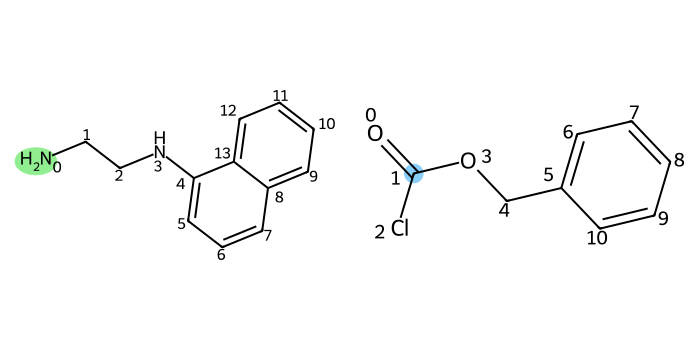

,MAA Value [kJ/mol],Est. Error [kJ/mol],Type
Atom ID,,,
2.1,278.009302,18.562567,Ester
1.12,97.305099,18.965674,Double bond
2.8,94.570853,17.797151,Double bond
2.10,88.538623,10.720238,Double bond
2.6,88.538623,10.720238,Double bond
1.6,84.444567,16.507670,Double bond
1.9,83.552732,17.825779,Double bond
2.9,79.667608,8.580240,Double bond
2.7,79.667608,8.580240,Double bond


In [5]:
# smiles = 'CC1=NN=C(O1)C(=O)Cl.NC(C)(C)C2=NC(=C(C(=O)N2C)O)C(=O)NCC3=CC=C(C=C3)F' # Raltegravir reaction

smiles = 'CCOC(=O)c1cc(Cl)n2nc(-c3ccc(Br)cc3F)cc2n1' # from Fig.3a in https://doi.org/10.1002/anie.202411296
smiles = 'NCCNc1cccc2ccccc12.O=C(Cl)OCc1ccccc1' # from Fig.3b in https://doi.org/10.1002/anie.202411296
# smiles = 'C=C(C)C(CC=O)CCC(C)=O' # from Fig.4b in https://doi.org/10.1021/jacs.4c00338

# smiles = 'Cc1ccc(C(=O)c2ccc(Cl)[nH]2)cc1' # Tolmetin
# smiles = 'Cc1ccc(C(=O)c2ccc(Cl)[n-]2)cc1' # Tolmetin deprotonated

# smiles = 'O=C(O)c1c[nH]c2cc(Cl)c(F)cc2c1=O.C1CNCCN1' # Ciprofloxacin step 1
# smiles = 'O=C(O)c1c[nH]c2cc(N3CCNCC3)c(F)cc2c1=O.[CH+]1CC1' # Ciprofloxacin step 2 (Cyclopropyl trifluoromethanesulfonate: O=S(=O)(OC1CC1)C(F)(F)F)
# smiles = 'O=C(O)c1c[n-]c2cc(N3CCNCC3)c(F)cc2c1=O.[CH+]1CC1' # Ciprofloxacin step 2 deprotonated
# smiles = 'Oc1c(cnc2cc(Cl)c(F)cc12)C([O-])=O.C1CNCCN1' # Ciprofloxacin step 1 protonation according to MarvinSketch
# smiles = 'Oc1c(cnc2cc(Cl)c(F)cc12)C([O-])=O.C1C[NH2+]CCN1' # Ciprofloxacin step 1 protonation according to MarvinSketch
# smiles = 'Oc1c(cnc2cc(N3CC[NH2+]CC3)c(F)cc12)C([O-])=O.[CH+]1CC1' # Ciprofloxacin step 2 protonation according to MarvinSketch

# smiles = 'O=C(O)c1c[nH]c2cc(Cl)c(F)cc2c1=O.[CH+]1CC1' # Ciprofloxacin suggested step 1 (Cyclopropyl trifluoromethanesulfonate: O=S(=O)(OC1CC1)C(F)(F)F)
# smiles = 'O=C(O)c1c[n-]c2cc(Cl)c(F)cc2c1=O.[CH+]1CC1' # Ciprofloxacin suggested step 1 deprot (Cyclopropyl trifluoromethanesulfonate: O=S(=O)(OC1CC1)C(F)(F)F)
# smiles = 'O=C(O)c1cn(C2CC2)c2cc(Cl)c(F)cc2c1=O.C1C[NH2+]CCN1' # Ciprofloxacin suggested step 2
# smiles = 'O=C(C1=C(O)C2C(=CC(=C(C=2)F)Cl)N=C1)[O-].[CH+]1CC1' # Ciprofloxacin suggested step 1 protonation according to MarvinSketch (Cyclopropyl trifluoromethanesulfonate: O=S(=O)(OC1CC1)C(F)(F)F)
# smiles = 'O=C(O)c1cn(C2CC2)c2cc(Cl)c(F)cc2c1=O.C1C[NH2+]CCN1' # Ciprofloxacin suggested step 2 protonation according to MarvinSketch
# smiles = 'O=C([O-])c1cn(C2CC2)c2cc(Cl)c(F)cc2c1=O.C1C[NH2+]CCN1' # Ciprofloxacin suggested step 2 protonation according to MarvinSketch pH=7

smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True) # canonicalize input smiles
name = hashlib.md5(smiles.encode()).hexdigest() # SMILES MUST BE CANONICALIZED
result_svg, df_elec, df_nuc, elec_names_list, MAA_values, elec_sites_list, nuc_names_list, MCA_values, nuc_sites_list = pred_MAA_and_MCA(smiles, name)
df_elec = df_elec.set_index('Atom ID')
df_nuc = df_nuc.set_index('Atom ID')

print('Name:', name)
print('SMILES:', smiles)
display(SVG(result_svg))
side_by_side(df_elec.drop(columns=['Reactant']).style.set_table_attributes("style='display:inline'").set_caption('MAA (Error cutoff 30 kJ/mol)'), df_nuc.drop(columns=['Reactant']).style.set_table_attributes("style='display:inline'").set_caption('MCA (Error cutoff 25 kJ/mol)'))